<h1>A/B Hypothesis Testing: Ad campaign performance </h1>

This repository contains code to solving an Ad-Campaign business problem, using A/B testing.

The main objective of this project is to test if the ads that an advertising company ran resulted in a significant lift in brand awareness.

<h3>Data</h3>
The data for this project is a “Yes” and “No” response of online users to the following question:

**Q: Do you know the brand Lux?**
O  Yes		O  No
		
The users that were presented with the questionnaire above were chosen according to the following rule:

* Control: users who have been shown a dummy ad
* Exposed: users who have been shown a creative ad that was designed by SmartAd for the client. 

Null Hypothesis:- The creative ad designed by SmartAd did not result in a significant lift in brand awareness.

**Data Attributes**

Brand Impact Optimiser (BIO), a lightweight questionnaire, served with every campaign to determine the impact of the creative, the ad they design, on various upper funnel metrics, including memorability and brand sentiment. 

*	auction_id: the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.
*	experiment: which group the user belongs to - control or exposed.
*	date: the date in YYYY-MM-DD format
*	hour: the hour of the day in HH format.
*	device_make: the name of the type of device the user has e.g. Samsung
*	platform_os: the id of the OS the user has. 
*	browser: the name of the browser the user uses to see the BIO questionnaire.
*	yes: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.
*	no: 1 if the user chooses the “No” radio button for the BIO questionnaire.


In [2]:
#Loading useful packages
import datetime
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report


In [3]:
path = "../data/AdSmartABdata.csv"
data=pd.read_csv(path)
data.tail()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,7/3/2020,15.0,Generic Smartphone,6.0,Chrome Mobile,0.0,0.0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,7/4/2020,9.0,Generic Smartphone,6.0,Chrome Mobile,0.0,0.0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,7/5/2020,15.0,Samsung SM-A515F,6.0,Samsung Internet,0.0,0.0
8076,fffbb9ff-568a-41a5-a0c3-6866592f80d8,control,7/10/2020,14.0,Samsung SM-G960F,6.0,Facebook,0.0,0.0
8077,>>>>>>> 46d2623a0f55fa7cc6e8ede17edef4b4ee8d4332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8078 entries, 0 to 8077
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   auction_id   8078 non-null   object 
 1   experiment   8077 non-null   object 
 2   date         8077 non-null   object 
 3   hour         8077 non-null   float64
 4   device_make  8077 non-null   object 
 5   platform_os  8077 non-null   float64
 6   browser      8077 non-null   object 
 7   yes          8077 non-null   float64
 8   no           8077 non-null   float64
dtypes: float64(4), object(5)
memory usage: 568.1+ KB


In [5]:
data.isnull().sum()

auction_id     0
experiment     1
date           1
hour           1
device_make    1
platform_os    1
browser        1
yes            1
no             1
dtype: int64

In [6]:
#Check whether the null values are coming from one row
data[data.isnull().any(axis=1)]

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
8077,>>>>>>> 46d2623a0f55fa7cc6e8ede17edef4b4ee8d4332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#drop null row
data.drop([8077],inplace=True)

data[data.isnull().any(axis=1)]

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no


In [8]:
data.sample()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
4465,8e55a2ce-71f1-4a99-9750-ab36ea435bce,exposed,7/8/2020,2.0,Samsung SM-G965F,6.0,Facebook,0.0,0.0


In [9]:
print('Device Make', data.device_make.nunique())
print('OS Platform',data.platform_os.nunique())
print('Browser',data.browser.nunique())

Device Make 270
OS Platform 3
Browser 15


In [10]:
data.groupby('experiment').agg({'device_make':'nunique','platform_os':'nunique','browser':'nunique'})

,device_make,platform_os,browser
experiment,,,
control,169,2,12
exposed,218,3,12


It seems that there are ids that have 0 for both yes and no - this means that a user saw the question "Do you know the brand Lux" and chose not to answer

Given the data that we have, answering this question is the only way to measure brand awareness. Hence, we need to drop these rows.

In [11]:
print(data.experiment.value_counts())
print(data[(data.yes==0)&(data.no==0)].experiment.value_counts())

experiment
control    4071
exposed    4006
Name: count, dtype: int64
experiment
control    3485
exposed    3349
Name: count, dtype: int64


In [12]:
fig = px.histogram(data,x='experiment',title='Count of users who participated in the experiment')
fig.show()

In [13]:
fig = px.histogram(data[(data.yes==0)&(data.no==0)],x='experiment',title='Count of users who did not answer the question')
fig.show()

There's no notable trend in those who didn't answer the question (e.g. we can't say that most of the users who didn't answer the question came from group x)

<h2>Data Preprocessing</h2>

In [14]:
#create a new df after dropping rows where both yes and no columns == 0
df = data[~((data['yes']==0) & (data['no']==0))]
#convert date columns to datetime
df['date'] = pd.to_datetime(df['date'])
#extract day column, may be there's a pattern
df['day'] = pd.Series(df['date'].dt.day_name())
#drop columns auction_id, no because that information is on column yes
df.drop(['auction_id','no'],axis=1,inplace=True)
#rename yes column to response where 1 means yes and 0 means no
df.rename({'yes':'response'},axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
df.sample()

,experiment,date,hour,device_make,platform_os,browser,response,day
203,control,2020-07-03,15.0,Samsung SM-G970F,6.0,Samsung Internet,0.0,Friday


In [15]:
#create a new df after dropping rows where both yes and no columns == 0
df = data[~((data['yes']==0) & (data['no']==0))]
#convert date columns to datetime
df['date'] = pd.to_datetime(df['date'])
#extract day column, may be there's a pattern
df['day'] = pd.Series(df['date'].dt.day_name())

In [16]:
#drop columns auction_id, no because that information is on column yes
df.drop(['auction_id','no'],axis=1,inplace=True)
#rename yes column to response where 1 means yes and 0 means no
df.rename({'yes':'response'},axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
df.sample()

,experiment,date,hour,device_make,platform_os,browser,response,day
639,exposed,2020-07-04,14.0,Generic Smartphone,6.0,Chrome Mobile,0.0,Saturday


<h2>EDA</h2>

In [17]:
dates = ['7/3/2020','7/4/2020','7/5/2020','7/6/2020','7/7/2020','7/8/2020','7/9/2020','7/10/2020']
fig = px.histogram(df,x='date',barmode='group', color='response',hover_data=['day'],
                   title='Number of responses per date',category_orders={'date':dates})
fig.show()

In [18]:
df.groupby('date')['day'].unique()

date
2020-07-03       [Friday]
2020-07-04     [Saturday]
2020-07-05       [Sunday]
2020-07-06       [Monday]
2020-07-07      [Tuesday]
2020-07-08    [Wednesday]
2020-07-09     [Thursday]
2020-07-10       [Friday]
Name: day, dtype: object

3rd July had the highest number of responses, it also happens to be a Friday and the first day of the experiment

10th is also a Friday, but it had a lower response than Wednesday and Thursday so we can't conclude with confidence that Fridays tend to have the highest number of repsonses.

The marketing strategy was probably more aggressive at the beginning of the experiment.

In [19]:
'''for date in dates:
    fig = px.histogram(df[df.date==date],x='hour',color='response',barmode='group',
                       title=f'Number of repsonses on {date}',category_orders={'day':dates})
    fig.show()'''

"for date in dates:\n    fig = px.histogram(df[df.date==date],x='hour',color='response',barmode='group',\n                       title=f'Number of repsonses on {date}',category_orders={'day':dates})\n    fig.show()"

In [20]:
fig = px.histogram(df,x='browser',color='response',barmode='group',title='Number of responses by Browser')
fig.show()

Chrome Mobile Webview and Chrome Mobile had the highest responses

In [21]:
fig = px.histogram(df,x='platform_os',color='response',barmode='group',title='Number of responses by Platform OS')
fig.show()

Most responses were from OS 6

In [22]:
df.device_make.nunique()

115

In [23]:
df.device_make.value_counts()

device_make
Generic Smartphone    719
Samsung SM-G960F       45
Samsung SM-G950F       35
Samsung SM-G973F       22
Samsung SM-A202F       18
                     ... 
EVR-N29                 1
Samsung SM-G610F        1
IMO $2                  1
VFD 820                 1
XiaoMi Redmi S2         1
Name: count, Length: 115, dtype: int64

In [24]:
print('Shape',df.shape)
print('# of unique devices',df.device_make.nunique())
print('devices with counts above 10')
print(df.device_make.value_counts()[df.device_make.value_counts() > 10])
print('------------------------------')
print(len(df.device_make.value_counts()[df.device_make.value_counts() > 10].index.to_list()))

Shape (1243, 8)
# of unique devices 115
devices with counts above 10
device_make
Generic Smartphone     719
Samsung SM-G960F        45
Samsung SM-G950F        35
Samsung SM-G973F        22
Samsung SM-A202F        18
iPhone                  18
Samsung SM-G930F        16
Samsung SM-G975F        15
Samsung SM-A405FN       14
Samsung SM-A105FN       13
Nokia undefined$2$3     11
LG-$2                   11
Samsung SM-A505FN       11
Samsung SM-G935F        11
Samsung SM-G965F        11
Name: count, dtype: int64
------------------------------
15


Out of 115 unique devices only 15 have value count >10

One hot encoding the device_make column will result in a large dataset (115 unique device_make) and may introduce dimensional problems. 

To avoid this, we extract the brand name from the device_make other than 'Generic Smartphone' and one hot encode this column

Otherwise, consider dimensionality reduction techniques such as PCA

<h2>Feature Engineering</h2>

In [25]:
#create device_brand column
df['device_brand'] = df['device_make']
df['device_brand'] = [b.replace('-',' ',1).replace('_',' ',1).strip() for b in df.device_brand]
df['device_brand'] = [b if b == 'Generic Smartphone' else b.split(' ')[0] for b in df['device_brand']]
print(df.device_brand.nunique())
print(df.device_brand.unique()) 

41
['E5823' 'Generic Smartphone' 'Samsung' 'I3312' 'MRD' 'Moto' 'ELE' 'VOG'
 'LG' 'ANE' 'POT' 'OnePlus' 'STF' 'HTC' 'iPhone' 'XiaoMi' 'Nokia' 'Huawei'
 'Nokia$2$3' 'LYA' 'MAR' 'CLT' 'Pixel' 'G3311' 'YAL' 'SNE' 'VTR' 'VFD'
 'PRA' 'A0001' 'EVR' 'IMO' 'F3311' 'EML' 'TA' 'DLI' 'FIG' 'EVA' 'X4' 'PCT'
 'VCE']


In [26]:
#rename Nokia$2$3
df['device_brand'] = ['Nokia' if brand == 'Nokia$2$3' else brand for brand in df['device_brand']]
print(df.device_brand.nunique())
print(df.device_brand.value_counts())

40
device_brand
Generic Smartphone    719
Samsung               367
Nokia                  20
iPhone                 18
Pixel                  11
LG                     11
POT                     8
XiaoMi                  6
I3312                   6
ELE                     6
VOG                     6
ANE                     6
MAR                     6
CLT                     5
OnePlus                 5
HTC                     4
Moto                    4
MRD                     4
LYA                     3
VFD                     3
VTR                     2
FIG                     2
PRA                     2
G3311                   2
Huawei                  2
EVA                     1
X4                      1
EML                     1
PCT                     1
DLI                     1
TA                      1
E5823                   1
F3311                   1
IMO                     1
EVR                     1
A0001                   1
SNE                     1
YAL                   

In [27]:
fig = px.histogram(df,x='device_brand',barmode='group',title='Number of responses by Device')
fig.show()

Encode Categorical Columns

In [28]:
#reorder columns so that response column comes first
df_enc = pd.get_dummies(data=df,columns=['experiment','browser','device_brand','day','platform_os'])
#drop date and device_make 
df_enc.drop(['date','device_make'],axis=1,inplace=True)
print(df_enc.shape)
df_enc.sample()

(1243, 61)


,hour,response,experiment_control,experiment_exposed,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,...,device_brand_iPhone,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,platform_os_5.0,platform_os_6.0
422,15.0,1.0,True,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True


<h3>ML model with MLOps</h3>

In [29]:
#frac=1 shuffles the whole dataset
train,val,test = np.split(df_enc.sample(frac=1),[int(0.6*len(df_enc)),int(0.8*len(df_enc))])

In [30]:
df.response.value_counts()

response
0.0    671
1.0    572
Name: count, dtype: int64

Because the 'yes' values in the response column are fewer, we oversample to make them balanced. But only for the train set

In [31]:
df_enc.sample()

,hour,response,experiment_control,experiment_exposed,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,...,device_brand_iPhone,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,platform_os_5.0,platform_os_6.0
924,10.0,1.0,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [32]:
ml_df = df.copy()
ml_df.drop(['date','device_make'],axis=1,inplace=True)
ml_df = ml_df[['response','experiment', 'hour', 'platform_os', 'browser', 'day', 'device_brand']]
browser = ml_df.drop(['platform_os'],axis=1)
platform = ml_df.drop(['browser'],axis=1)
browser.reset_index(drop=True,inplace=True)
platform.reset_index(drop=True,inplace=True)

In [33]:
browser.sample()

,response,experiment,hour,browser,day,device_brand
755,0.0,control,17.0,Chrome Mobile,Saturday,Generic Smartphone


**Create dummies for browser and  device columns**

In [34]:
platform = pd.get_dummies(data=platform,columns=['experiment','device_brand','day','platform_os'])
browser = pd.get_dummies(data=browser,columns=['experiment','device_brand','day','browser'])
browser.sample()

,response,hour,experiment_control,experiment_exposed,device_brand_A0001,device_brand_ANE,device_brand_CLT,device_brand_DLI,device_brand_E5823,device_brand_ELE,...,day_Tuesday,day_Wednesday,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,browser_Mobile Safari UI/WKWebView,browser_Samsung Internet
662,0.0,5.0,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [35]:
platform.sample()

,response,hour,experiment_control,experiment_exposed,device_brand_A0001,device_brand_ANE,device_brand_CLT,device_brand_DLI,device_brand_E5823,device_brand_ELE,...,device_brand_iPhone,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,platform_os_5.0,platform_os_6.0
1070,0.0,20.0,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [36]:
platform.to_csv('../data/platform.csv',header=True)
browser.to_csv('../data/browser.csv',header=True)

In [37]:
def scale_dataset(dataframe:pd.DataFrame,target_col='response',oversample=False):
    cols = dataframe.columns.tolist()
    cols.remove(target_col)
    
    X = dataframe[cols].values
    y = dataframe[target_col].values
    
    #standardise data to have a uniform scale
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    #split the dataset
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    #only oversample the train set
    #Oversampling generates new samples in the classes which are underepresented, so that they now match
    ros =RandomOverSampler()
    X_train,y_train = ros.fit_resample(X_train,y_train)
 
    #new_data = np.hstack((X,np.reshape(y,(-1,1))))
    #because we'll be using kfold validation, split the set into train and test
    return X_train,X_test,y_train,y_test

In [38]:
X_train_browser,X_test_browser,y_train_browser,y_test_browser = scale_dataset(browser)
X_train_platform,X_test_platform,y_train_platform,y_test_platform = scale_dataset(platform)

<h2>Building the model</h2>

**Loss function**

In [39]:
def loss_function(y_test, y_preds):
    #This is a classification problem. So metrics such as accuracy, precision, recall, f1 score are more appropriate
    print('--------------------------------------------------------------------')
    print('Classification Report')
    print(classification_report(y_test,y_preds))
    print('--------------------------------------------------------------------')

**Feature Importance**

In [40]:
def get_feature_importance(model_name,coefficients,num_of_features=10,is_browser=True):
    # Get feature names
    if is_browser:
        feature_names = browser.columns[browser.columns!='response']
    else:
        feature_names = platform.columns[platform.columns!='response']
    # Get feature coefficients (importance)
    feature_importance = pd.DataFrame({'feature':feature_names,'importance':coefficients})
    feature_importance.sort_values(by='importance',ascending=False,inplace=True)

    feature_importance = pd.DataFrame({'feature':feature_names,'importance':coefficients})
    feature_importance = feature_importance.reindex(feature_importance['importance'].abs().sort_values(ascending=False).index)
    #plot feature importance
    fig = px.bar(feature_importance[:num_of_features],x='feature',y='importance',title=f'Top {num_of_features} Features by Importance: {model_name}')
    fig.show()


**Logistic Regression Model**

In [41]:
def log_model(X_train,X_test,y_train,y_test,num_of_features=10,is_browser=True):
    kfold=KFold(n_splits=5,random_state=42,shuffle=True)
    model=LogisticRegression()
    #hyper-parameter tuning
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    print('Validation Accuracy: %.3f (%.3f)' %(np.mean(scores), np.std(scores)))
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    loss_function(y_test, y_pred)

    ##### FEATURE IMPORTANCE#####
    coefficients = model.coef_[0]
    return get_feature_importance(model_name='Logistic Regression',coefficients = coefficients,num_of_features=num_of_features,is_browser=is_browser)

In [42]:
log_model(X_train_browser,X_test_browser,y_train_browser,y_test_browser,num_of_features=15)

Validation Accuracy: 0.537 (0.022)
--------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.53      0.55      0.54       201
         1.0       0.45      0.42      0.43       172

    accuracy                           0.49       373
   macro avg       0.49      0.49      0.49       373
weighted avg       0.49      0.49      0.49       373

--------------------------------------------------------------------


This model has a relatively poor performance as an f1 score 0.52.
For category 0 , a precision of 0.52 means that of all the positive predictions that the model made, it only got 52% right. A recall of 0.53 means that of all the actual positives, the model only captured 53% 

In [43]:
log_model(X_train_platform,X_test_platform,y_train_platform,y_test_platform,num_of_features=15,is_browser=False)

Validation Accuracy: 0.514 (0.028)
--------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.53      0.55      0.54       201
         1.0       0.45      0.44      0.45       172

    accuracy                           0.50       373
   macro avg       0.49      0.49      0.49       373
weighted avg       0.50      0.50      0.50       373

--------------------------------------------------------------------


**Decision Trees**

In [44]:
def decision_trees(X_train,X_test,y_train,y_test,num_of_features=10,is_browser=True):
    kfold=KFold(n_splits=5,random_state=42,shuffle=True)
    dtree=DecisionTreeClassifier()
    #hyper-parameter tuning
    scores = cross_val_score(dtree, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    print('Validation Accuracy: %.3f (%.3f)' %(np.mean(scores), np.std(scores)))
    dtree.fit(X_train,y_train)
    y_pred = dtree.predict(X_test)
    loss_function(y_test, y_pred)
    
    importance = dtree.feature_importances_
    get_feature_importance(model_name='Decision Trees',coefficients=importance,num_of_features=num_of_features,is_browser=is_browser)

In [45]:
decision_trees(X_train_browser,X_test_browser,y_train_browser,y_test_browser,num_of_features=15)

Validation Accuracy: 0.546 (0.016)
--------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.54      0.49      0.52       201
         1.0       0.46      0.51      0.49       172

    accuracy                           0.50       373
   macro avg       0.50      0.50      0.50       373
weighted avg       0.51      0.50      0.50       373

--------------------------------------------------------------------


In [46]:
decision_trees(X_train_platform,X_test_platform,y_train_platform,y_test_platform,num_of_features=15,is_browser=False)

Validation Accuracy: 0.510 (0.010)
--------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.57      0.65      0.61       201
         1.0       0.51      0.44      0.47       172

    accuracy                           0.55       373
   macro avg       0.54      0.54      0.54       373
weighted avg       0.55      0.55      0.54       373

--------------------------------------------------------------------


**XGBoost**

In [55]:
def xgboost_model(X_train,X_test,y_train,y_test,num_of_features=10,is_browser=True):
    kfold=KFold(n_splits=5,random_state=42,shuffle=True)
    model=XGBClassifier()
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    print('Validation Accuracy: %.3f (%.3f)' %(np.mean(scores), np.std(scores)))
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    loss_function(y_test, y_pred)
    
    
    # Fit model using each importance as a threshold
    thresholds = np.sort(model.feature_importances_)
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier(verbosity=0)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_test, predictions)
        #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

    coefficients = model.feature_importances_
    get_feature_importance('XGBOOST',coefficients,num_of_features,is_browser)

In [56]:
xgboost_model(X_train_browser,X_test_browser,y_train_browser,y_test_browser)

Validation Accuracy: 0.526 (0.044)
--------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.56      0.42      0.48       201
         1.0       0.47      0.61      0.53       172

    accuracy                           0.51       373
   macro avg       0.51      0.51      0.51       373
weighted avg       0.52      0.51      0.50       373

--------------------------------------------------------------------


Validation Accuracy: 0.487 (0.021)
--------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.55      0.47      0.51       201
         1.0       0.47      0.55      0.51       172

    accuracy                           0.51       373
   macro avg       0.51      0.51      0.51       373
weighted avg       0.52      0.51      0.51       373

--------------------------------------------------------------------


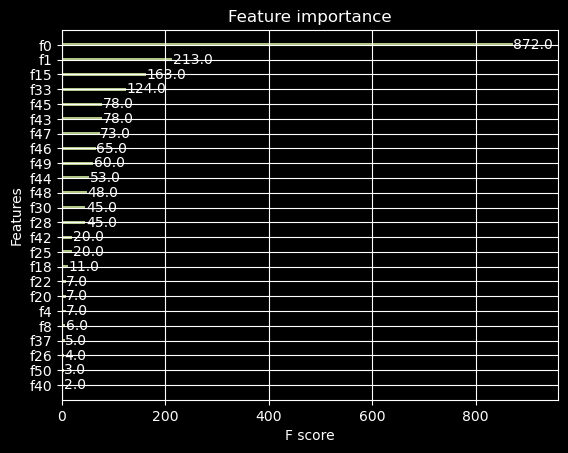

In [ ]:
xgboost_model(X_train_platform,X_test_platform,y_train_platform,y_test_platform)